# 1. Multi-class classification with Custom ResNet model

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [3]:
if torch.cuda.is_available():
   DEVICE = torch.device('cuda')
else:
   DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

Using PyTorch version: 2.1.0+cu121 Device: cpu


In [4]:
BATCH_SIZE = 32
EPOCHS = 10

In [17]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root="../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:02<00:00, 79768887.89it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


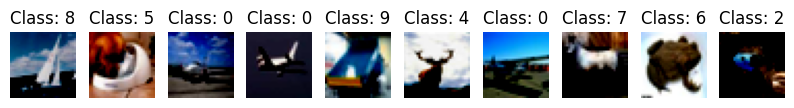

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
#Question 1.
#Building custum ResNet model

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1): #in_planes: 이전 레이어의 출력 channel 수 또는 입력 feature map의 depth
                                                       #planes: 현재 레이어의 출력 채널 수 또는 feature map의 depth
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes) #nn.BatchNorm2d: 2d input에 대한 batch normalization
                                          #planes: feature map의 channel 수
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes = 10): #num_clsses: output class의 개수
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8) #avaerage pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out) #linear layer
        return out

In [9]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [15]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader): #enumerate: 순서가 있는iterable 자료형을 input으로 index와 동시에 반환
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0: #배치 인덱스batch_idx가 log interval로 나눠떨어질 때 ture # 특정 간격(log_interval)마다 훈련 손실을 출력
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [19]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [20]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 1.082298
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 0.956522
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 0.823417
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.064832
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 0.839115
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.122956
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.724462
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 0.712311

[EPOCH: 1], 	Test Loss: 0.8198, 	Test Accuracy: 71.35 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.722114
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 0.732127
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.759298
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.892836
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.903753
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.491319
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.669812
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.515575

[EPOCH: 2], 	Test Loss: 0.6973, 	Test Accuracy: 75.60 % 